In [0]:
!git clone https://github.com/ViiSkor/Lung_image_segmentation

Cloning into 'Lung_image_segmentation'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
from Lung_image_segmentation.helper import *
from Lung_image_segmentation.model import UNet 
from Lung_image_segmentation.losses import bce_logdice_loss
from Lung_image_segmentation.metrics import mean_iou
import os
import glob
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau
from google.colab import drive, files

In [0]:
drive.mount('/content/gdrive')

In [0]:
!tar -zxvf "/content/gdrive/My Drive/dataset.tar.gz"

In [0]:
IMAGE_PATHS = glob.glob("/content/dataset/images/*")
MASK_PATHS = glob.glob("/content/dataset/masks/*")
TRAIN_DATASET_DIR = "/content/train_dataset/"
TRAIN_IMAGES_DIR = "/content/train_dataset/images/"
TRAIN_MASKS_DIR = "/content/train_dataset/masks/"
TEST_DATASET_DIR = "/content/test_dataset/"
TEST_IMAGES_DIR = "/content/test_dataset/images/"
TEST_MASKS_DIR = "/content/test_dataset/masks/"
INPUT_SHAPE = (512, 512, 3)
BATCH_SIZE = 8
EPOCHS = 20

# Load data

In [0]:
print("Image dataset: "+ str(len(IMAGE_PATHS)) + "\nMask dataset: " + str(len(MASK_PATHS)))

Image dataset: 800
Mask dataset: 704


In [0]:
without_mask, dataset_image_paths, dataset_mask_paths = get_dataset_pathes(IMAGE_PATHS, MASK_PATHS)

In [0]:
train_image_paths, train_mask_paths, test_image_paths, test_mask_paths = split_test_train(dataset_image_paths, dataset_mask_paths)

In [0]:
n_train = len(train_image_paths)
n_test = len(test_image_paths)

In [0]:
print("Train dataset: "+ str(len(train_image_paths)) + "\nTest dataset: " + str(len(test_image_paths)))

Train dataset: 563
Test dataset: 141


In [0]:
creat_dataset_dir(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, train_image_paths, train_mask_paths)
creat_dataset_dir(TEST_IMAGES_DIR, TEST_MASKS_DIR, test_image_paths, test_mask_paths)

Found 563 images belonging to 1 classes.
Found 563 images belonging to 1 classes.


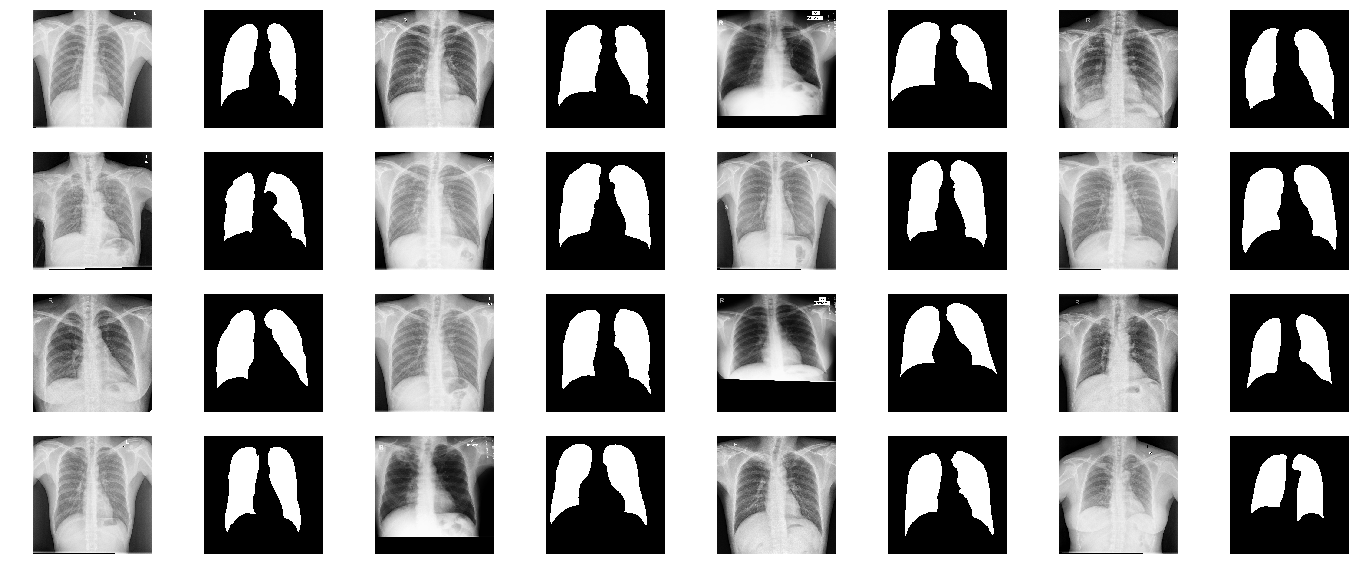

In [0]:
gen = generator(1, TRAIN_DATASET_DIR)
plot_data(dataset_image_paths, dataset_mask_paths, gen)

# Create model

In [0]:
unet = UNet(bce_logdice_loss, [mean_iou])
model = unet.get_model(INPUT_SHAPE)

# Train

In [0]:
train_gen = generator(BATCH_SIZE, TRAIN_DATASET_DIR, augmentation=True)
test_gen = generator(BATCH_SIZE, TEST_DATASET_DIR)

In [0]:
checkpointer = ModelCheckpoint('model_lung_seg.h5', verbose=1, save_best_only=True)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                              verbose=1, mode='auto', cooldown=4, min_lr=1e-5)
history = model.fit_generator(train_gen, epochs=EPOCHS, 
                              steps_per_epoch=int(n_train / BATCH_SIZE), 
                              validation_data=test_gen, 
                              validation_steps=int(n_test / BATCH_SIZE),  
                              callbacks=[checkpointer, reduce_LR], 
                              use_multiprocessing=True)

Epoch 1/20
Found 141 images belonging to 1 classes.
Found 563 images belonging to 1 classes.
Found 141 images belonging to 1 classes.
Found 563 images belonging to 1 classes.
70/70 [==============================] - 259s 4s/step - loss: 1.0490 - mean_iou: 0.5645 - val_loss: 0.2255 - val_mean_iou: 0.7541

Epoch 00001: val_loss improved from inf to 0.22551, saving model to model_lung_seg.h5
Epoch 2/20
70/70 [==============================] - 238s 3s/step - loss: 0.1510 - mean_iou: 0.8070 - val_loss: 0.1446 - val_mean_iou: 0.8403

Epoch 00002: val_loss improved from 0.22551 to 0.14463, saving model to model_lung_seg.h5
Epoch 3/20
70/70 [==============================] - 224s 3s/step - loss: 0.1217 - mean_iou: 0.8586 - val_loss: 0.1170 - val_mean_iou: 0.8731

Epoch 00003: val_loss improved from 0.14463 to 0.11696, saving model to model_lung_seg.h5
Epoch 4/20
70/70 [==============================] - 224s 3s/step - loss: 0.1082 - mean_iou: 0.8828 - val_loss: 0.1266 - val_mean_iou: 0.8906

Ep

# Result

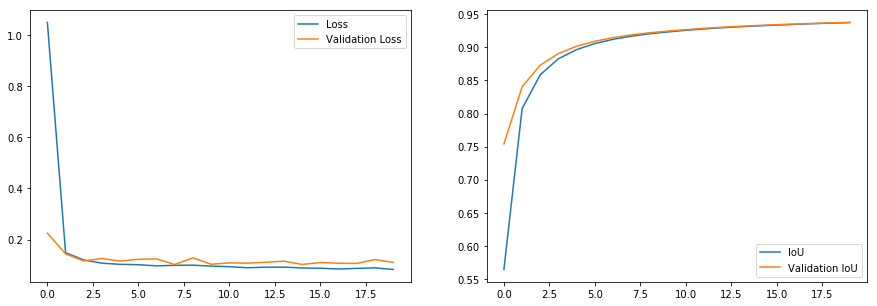

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(np.array(history.history['mean_iou']), '-',  label = 'IoU')
ax2.plot(np.array(history.history['val_mean_iou']), '-', label = 'Validation IoU')
ax2.legend()

In [0]:
X, y = next(generator(16, TEST_DATASET_DIR))

Found 141 images belonging to 1 classes.
Found 141 images belonging to 1 classes.


In [0]:
prediction = model.predict(X, verbose=1)

16/16 [==============================] - 1s 86ms/step


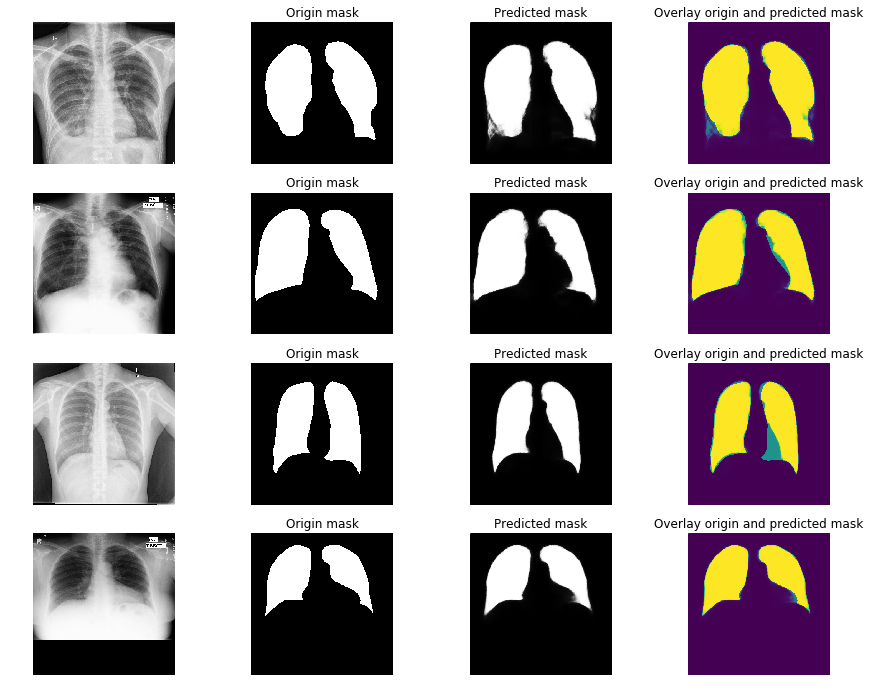

In [0]:
plot_result(X, y, prediction, 4)

# Cells for getting mask for your X-ray

In [0]:
files.upload()

In [0]:
image = cv2.imread('/content/image_from_internet.jpg')
image = cv2.resize(image, (512, 512), interpolation = cv2.INTER_AREA)
image = image / 255
x = np.array([image])
model.load_weights('/content/model_lung_seg.h5')
prediction = model.predict(x, verbose=1)

1/1 [==============================] - 0s 171ms/step


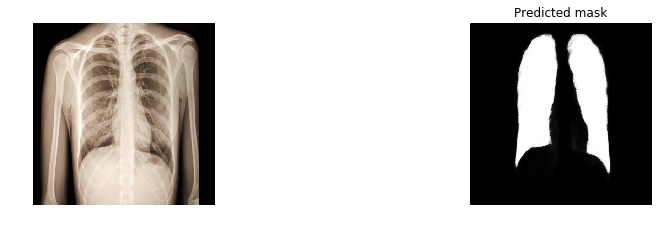

In [0]:
fig = plt.figure(figsize=(15, 12))
    
plt.subplot(1, 4, 1)
plt.imshow(image[:, :, :])
plt.axis('off')
      
plt.subplot(1, 4, 3)
plt.gca().set_title('Predicted mask')
plt.imshow(prediction[0, :, :, 0], cmap='gray')
plt.axis('off')
    
plt.show()